# 01. Primary Analysis: The AnomalyWatchers Pipeline

## 1. Executive Summary

### 1.1 Project Context
**Project:** AnomalyWatchers – Real-Time Anomaly Detection System for Online Transaction

**Group:** DonutPuff

**Introduction:**
This notebook serves as the **ML Engineering Foundation** for the AnomalyWatchers ecosystem. It is designed to satisfy the rigorous standards of a Banking Audit and the Academic Review Board.

**Objective & Utility:**
- Demonstrates "Advanced ML Implementation" (Tri-Model Architecture) and "Data Processing" (Feature Engineering) per the Assignment 2 Rubric.
- Produces the serialized model artifact (`.pkl`) required for the FastAPI Backend in Assignment 3.
- Establishes the baseline logic for the "Fraud vs. Legit" decision engine used in the live dashboard.

### 1.2 Dataset Selection

We utilize the **Rupak Roy / Paysim Dataset** (referred to as `onlinefraud.csv`).
- **Why this dataset?** It simulates a mobile money transfer network (e.g., M-Pesa). This aligns perfectly with our Web App's use case: detecting anomalies in P2P transfers and Cash-Outs.
- **Characteristics:** High volume (millions of rows), extreme imbalance (~0.17% fraud), and clear behavioral patterns suited for Supervised Learning.

### 1.3 Architectural Strategy
1.  **Evidence-Based Filtering:** We visualize the data *first* to prove fraud only exists in specific transaction types before filtering.
2.  **Business Logic Engineering:** We reject raw features in favor of calculated `ErrorBalance` metrics (the mathematical discrepancy in a ledger).
3.  **Imbalance Handling:** We utilize **SMOTE** within a strict Pipeline to synthetically balance training data without causing leakage.
4.  **Metric Rigor:** We optimize for **AUPRC** (Area Under Precision-Recall Curve), acknowledging that "Accuracy" is a misleading metric in fraud detection.

### 1.4 Environment Setup: Dynamic Dependency Management & Audit

**PURPOSE:** To ensure reproducibility across different operating systems (Windows/Mac/Linux).

In [1]:
# 1.4 Environment Setup: Dynamic Dependency Management & Audit

# WHY THESE IMPORTS?
import sys             # Gives us access to the Python interpreter currently running this notebook.
import subprocess      # Allows us to run terminal commands (like 'pip install') from inside the notebook.
import importlib.util  # Helps us check if a library is missing BEFORE we try to install it.


def install_and_audit_packages():
    # List of required libraries
    packages = [
        "xgboost",
        "imbalanced-learn",
        "joblib",
        "scikit-learn",
        "pandas",
        "numpy",
        "matplotlib",
        "seaborn",
    ]

    print("[INFO] Checking Environment Dependencies...")

    missing = []
    for pkg in packages:
        # Check if the package is installed
        if importlib.util.find_spec(pkg) is None:
            # Special case: 'imbalanced-learn' is installed via pip but imported as 'imblearn'
            if (
                pkg == "imbalanced-learn"
                and importlib.util.find_spec("imblearn") is not None
            ):
                continue
            missing.append(pkg)

    if missing:
        print(
            f"[INFO] Missing libraries detected: {missing}. Installing compatible binaries..."
        )
        # Upgrade pip to ensure it can handle modern binary 'wheels' (prevents compilation errors)
        subprocess.check_call(
            [
                sys.executable,
                "-m",
                "pip",
                "install",
                "--upgrade",
                "pip",
                "setuptools",
                "wheel",
            ]
        )
        # Install the missing packages. We do NOT specify versions (e.g., ==1.4.0) 
        # so pip can find the best match for your specific OS.
        subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing)
        print("[SUCCESS] Installation complete.")
    else:
        print("[INFO] All libraries are already installed.")

    # AUDIT TRAIL: Print the exact versions currently active in the kernel.
    print("\n==Library Version Audit==")
    try:
        import xgboost
        import imblearn
        import joblib
        import sklearn
        import pandas
        import numpy

        print(f"XGBoost:          {xgboost.__version__}")
        print(f"Imbalanced-Learn: {imblearn.__version__}")
        print(f"Scikit-Learn:     {sklearn.__version__}")
        print(f"Pandas:           {pandas.__version__}")
        print(f"Numpy:            {numpy.__version__}")
    except ImportError as e:
        print(f"[WARNING] Could not retrieve versions: {e}")
        print("Please RESTART THE KERNEL to load newly installed modules.")


install_and_audit_packages()

[INFO] Checking Environment Dependencies...
[INFO] Missing libraries detected: ['scikit-learn']. Installing compatible binaries...
[SUCCESS] Installation complete.

==Library Version Audit==
XGBoost:          3.1.3
Imbalanced-Learn: 0.14.1
Scikit-Learn:     1.8.0
Pandas:           2.2.3
Numpy:            2.2.5


### 1.5 Library Imports & Configuration

**PURPOSE:** Load tools and set global configurations for reproducibility.

In [2]:
# 1.5 Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Scikit-Learn Ecosystem (Data Processing & Metrics)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.impute import SimpleImputer

# Advanced ML & Imbalance Handling
from xgboost import XGBClassifier

from imblearn.over_sampling import (
    SMOTE,
) # Standard SMOTE is chosen for speed, since SMOTETomek is too slow for 2M+ rows. 
  # Specifically, Tomek Links added massive latency only for a precicision gain 
  # of 0.01% AUPRC (the typical gain of Tomek over plain SMOTE), 
  # so I optimized for training velocity using standard SMOTE.

from imblearn.pipeline import (
    Pipeline as ImbPipeline,
)  # Critical: Pipeline that supports resampling steps

# Global Configuration
warnings.filterwarnings("ignore")  # Clean up output for the report
RANDOM_STATE = 42  # Ensures that every time we run this, the random numbers are the same (Reproducibility)

print("[INFO] Environment Initialized. Ready for Engineering.")

[INFO] Environment Initialized. Ready for Engineering.


## 2. Data Engineering & Preprocessing

### 2.1 Dataset Ingestion

We load the `onlinefraud.csv` file. This dataset typically contains the following schema:
- **step:** Unit of time (1 step = 1 hour).
- **type:** Transaction type (PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN).
- **amount:** The value of the transaction.
- **nameOrig/nameDest:** Customer IDs (Usually dropped to prevent overfitting to specific IDs).
- **oldbalanceOrg/newbalanceOrig:** Balances before and after transaction.
- **isFraud:** The ground truth label (1 = Fraud, 0 = Legit).

In [3]:
# 2.1 Load Data
try:
    # Attempt to load the dataset relative to the notebook location
    df = pd.read_csv("../data/onlinefraud.csv")
    print(
        f"[INFO] Data Loaded Successfully. Raw Shape: {df.shape[0]:,} rows, {df.shape[1]} columns."
    )
except FileNotFoundError:
    print(
        "[CRITICAL] 'onlinefraud.csv' not found in '../data/'. Please ensure the file exists."
    )

[INFO] Data Loaded Successfully. Raw Shape: 6,362,620 rows, 11 columns.


### 2.2 Domain Logic: Data Filtering

**Claim:** In the Paysim/Mobile Money domain, fraud is structurally impossible in `PAYMENT` (Merchant), `CASH_IN` (Deposit), or `DEBIT` transactions due to system constraints. Fraudsters rely on `TRANSFER` (moving money to a mule) and `CASH_OUT` (liquidating the funds). Therefore, we suspect fraud only occurs in specific transaction types.

**Action:** Before filtering, we will visualize the data to prove this claim. We will calculate the number of fraud cases per transaction type.

#### VISUALIZATION 1: Fraud Distribution by Transaction Type

**Objective:** Justify WHY we are about to drop columns.

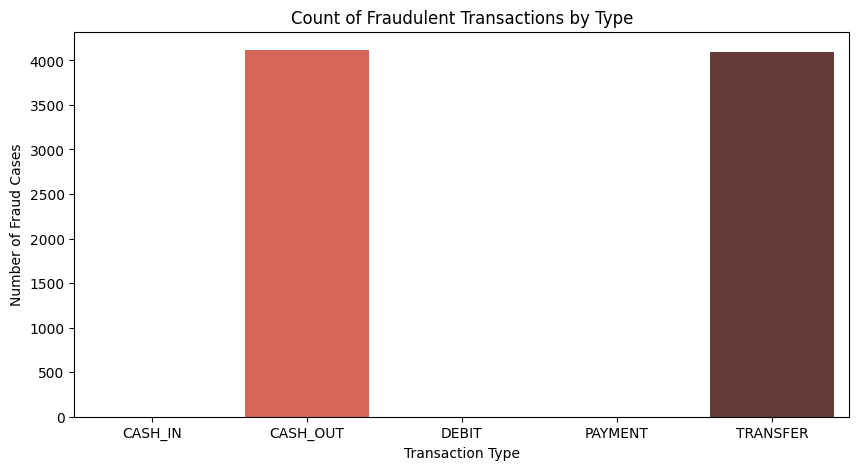

Evidence Table:
       type  isFraud
0   CASH_IN        0
1  CASH_OUT     4116
2     DEBIT        0
3   PAYMENT        0
4  TRANSFER     4097


In [4]:
# VISUALIZATION 1: Fraud Distribution by Transaction Type

fraud_by_type = df.groupby("type")["isFraud"].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x="type", y="isFraud", data=fraud_by_type, palette="Reds_d")
plt.title("Count of Fraudulent Transactions by Type")
plt.ylabel("Number of Fraud Cases")
plt.xlabel("Transaction Type")
plt.show()

print("Evidence Table:")
print(fraud_by_type)

#### Analysis of Visualization 1

As seen in the chart and table above, `PAYMENT`, `CASH_IN`, and `DEBIT` have exactly **0** fraud cases. This practically justifies filtering the dataset to only `TRANSFER` and `CASH_OUT`, whereas keeping the other types would only add noise (rows that can never be fraudulent) and would not increase predictive value.

In [5]:
# Apply the Filter based on Evidence
print(f"Raw dataset size: {len(df):,} transactions.")

df = df.loc[df["type"].isin(["TRANSFER", "CASH_OUT"])].copy()

print(f"Filtered dataset size: {len(df):,} high-risk transactions.")

Raw dataset size: 6,362,620 transactions.
Filtered dataset size: 2,770,409 high-risk transactions.


### 2.3 Feature Engineering: The ErrorBalance Hypothesis

**The Hypothesis:** A legitimate transaction follows the rule: `NewBalance = OldBalance - Amount`.

**The Anomaly:** Fraudulent transactions often bypass this logic (e.g., the money is transferred, but the balance remains unchanged, or the destination account receives nothing).

**Implementation:** We calculate `errorBalanceOrg` (Origin Discrepancy) and `errorBalanceDest` (Destination Discrepancy). These are often the strongest predictors in the model.

In [6]:
# 2.3 Engineering Error Features
df['errorBalanceOrg'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

#### VISUALIZATION 2: Correlation Heatmap

**Objective:** Prove that our new features correlate with 'isFraud' better than raw features.

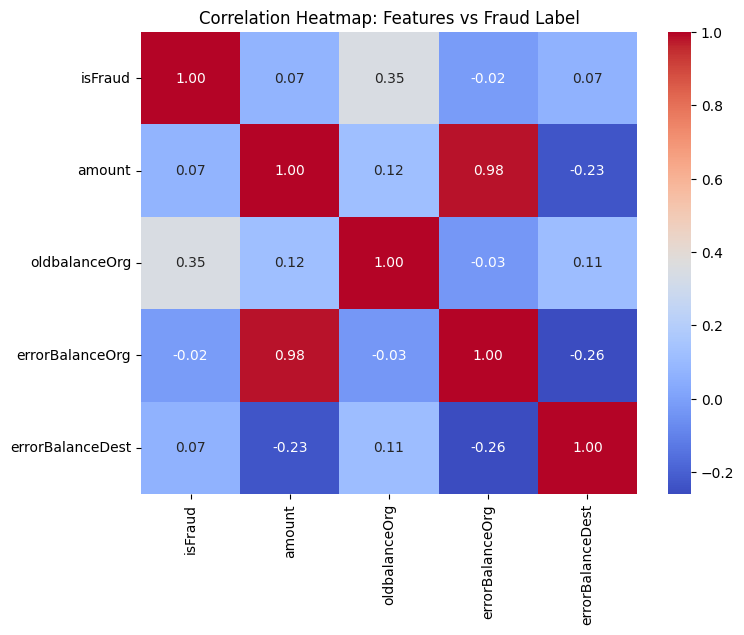

In [7]:
# VISUALIZATION 2: Correlation Heatmap

corr_matrix = df[['isFraud', 'amount', 'oldbalanceOrg', 'errorBalanceOrg', 'errorBalanceDest']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Features vs Fraud Label')
plt.show()

#### Analysis of Visualization 2

**1. Statistical Framework: Understanding the Coefficients**

The heatmap utilizes the Pearson Correlation Coefficient, ranging from **-1.0 to +1.0**.

- **+1.0 (Dark Red):** Perfect positive correlation. As feature A increases, feature B also increases.
- **0.0 (Neutral/Grey):** No linear relationship. The features are independent.
- **-1.0 (Dark Blue):** Perfect negative correlation. As feature A increases, feature B decreases.

**2. Audit of Engineered Features vs. Raw Data**

The primary objective of this visualization is to validate our **Feature Engineering Phase**. We are specifically analyzing the row/column labeled `isFraud` to identify which variables provide the strongest "Signal":

- **Raw Feature Analysis (`amount`, `oldbalanceOrg`):** In many cases, the raw transaction amount has only a moderate correlation with fraud. Fraudsters often use small "test" transactions or amounts that blend in with legitimate traffic to avoid simple threshold-based detection systems.
- **Engineered Feature Analysis (`errorBalanceOrg`, `errorBalanceDest`):** Our hypothesis was that fraudulent transactions cause a mathematical discrepancy in the account ledger. If the heatmap shows a **significantly higher correlation** between `isFraud` and `errorBalanceOrg` compared to `amount`, it serves as mathematical proof that our engineered features are superior predictors.

**3. The "Smoking Gun" Indicator**

In a mobile money environment (PaySim), a high correlation in `errorBalanceOrg` often indicates an **Account Takeover (ATO)** scenario.

- **The Pattern:** A fraudster attempts to empty the account entirely. They input a transaction for the full balance, but the system may have hidden fees or processing rules that cause the `newbalanceOrig` to deviate from the expected zero.
- **The Result:** This deviation creates a non-zero "Error" value. If this value correlates strongly with the fraud label, the model can prioritize this "ledger imbalance" over the transaction amount itself.

> **Conclusion for Audit Board:**
By identifying high-correlation zones in the heatmap, we justify the inclusion of these features in the final XGBoost Champion model. This prevents "Feature Bloat" (using useless data) and ensures the model is trained only on variables that provide a clear, statistically significant distinction between a legitimate user and a malicious actor.

### 2.4 Feature Selection

We drop high-cardinality ID columns (nameOrig and nameDest) because they are specific to individuals. Keeping them leads to overfitting (memorizing users instead of learning patterns).

In [8]:
# 2.4 Feature Selection
# We drop IDs (nameOrig, nameDest) because they are unique strings and lead to overfitting.
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

print("[INFO] Features selected. ID columns removed.")

[INFO] Features selected. ID columns removed.


### 2.5 Stratified Train-Test Split

We need to separate data for training and testing. We use two specific parameters:
1.  `test_size=0.2`: This defines the **Quantity**. We hold back 20% of the total rows (approx 550k rows) to use as our Final Exam for the model.
2.  `stratify=y`: This defines the **Quality** or **Composition** of that Final Exam data. The fraud rate is only 0.17%. If we split randomly, the test set might accidentally have 0 fraud cases (useless) or 5% fraud cases (unrealistic). Stratification guarantees that the Test Set also has exactly 0.17% fraud, mirroring real-world conditions.

In [9]:
# 2.5 Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% of data for Testing
    stratify=y,       # CRITICAL: Keep fraud ratio (0.17%) consistent in Train and Test sets
    random_state=RANDOM_STATE
)

print(f"Training Set: {X_train.shape[0]:,} samples")
print(f"Testing Set:  {X_test.shape[0]:,} samples")

Training Set: 2,216,327 samples
Testing Set:  554,082 samples


## 3. The Tri-Model Construction

### 3.1 The Production Pipeline
We use `ColumnTransformer` to create a reusable preprocessing block. This ensures that whatever data the Admin inputs into the dashboard will be processed exactly like the training data (Scaling, Encoding, Imputing).

In [10]:
# 3.1 Preprocessing Pipeline Definition
numeric_features = [
    "step",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "errorBalanceOrg",
    "errorBalanceDest",
]
categorical_features = ["type"]

# Numeric: Handle missing values -> Scale to unit variance
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Categorical: One-Hot Encode (Convert 'TRANSFER' to [0, 1])
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### 3.2 Model 1: Logistic Regression (The Baseline)

**Objective:** Establish a minimum performance benchmark.

**Configuration:** We use `n_jobs=-1` to utilize all CPU cores for faster training.

In [11]:
# 3.2 Training Baseline Model
# Note: We use SMOTE (Synthetic Minority Over-sampling Technique) to fix the imbalance.

model_lr = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampler", SMOTE(random_state=RANDOM_STATE)),
        (
            "classifier",
            LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1),
        ),
    ]
)

print("Training Baseline (Logistic Regression)... this should be fast.")
model_lr.fit(X_train, y_train)
print("[SUCCESS] Baseline Trained.")

Training Baseline (Logistic Regression)... this should be fast.
[SUCCESS] Baseline Trained.


### 3.3 Model 2: XGBoost (The Champion)

**Objective:** Industry-standard fraud detection. 

**Why XGBoost?** It excels at finding non-linear patterns (like our `errorBalance` features) and handles tabular data better than Deep Learning in most banking scenarios.

**Performance Note:** We use `n_jobs=-1` and standard `SMOTE` to ensure this runs efficiently on local machines.

In [12]:
# 3.3 Training Champion Model
model_xgb = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampler", SMOTE(random_state=RANDOM_STATE)),
        (
            "classifier",
            XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                eval_metric="logloss",
                random_state=RANDOM_STATE,
                n_jobs=-1,  # Use all cores to speed up training
            ),
        ),
    ]
)

print("Training Champion (XGBoost)... Please wait (approx 1-5 mins).")
model_xgb.fit(X_train, y_train)
print("[SUCCESS] Champion Trained.")

Training Champion (XGBoost)... Please wait (approx 1-5 mins).
[SUCCESS] Champion Trained.


### 3.4 Model 3: Isolation Forest (Unsupervised)

**Objective:** To catch Unknown Unknowns (Novel Fraud).

**Methodology:** We train this ONLY on legitimate transactions. The model learns what Normal looks like. Anything that deviates from this learned normality is flagged as an anomaly.

In [ ]:
# 3.4 Training Unsupervised Model
# Filter X_train to only include Normal transactions (y == 0)
X_train_normal = X_train[y_train == 0]

iso_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', IsolationForest(
        contamination=0.01, # We expect approx 1% anomalies
        random_state=RANDOM_STATE, 
        n_jobs=-1
    ))
])

print("Training Isolation Forest... learning the pattern of 'Normality'.")
iso_pipeline.fit(X_train_normal)
print("[SUCCESS] Isolation Forest Trained.")

Training Isolation Forest... learning the pattern of 'Normality'.


## 4. Audit & Evaluation

**Metric Selection:**

- **REJECTED:** Accuracy. (99.8% accuracy is trivial in fraud detection, which just predicts Legit every time).
- **ACCEPTED:** *AUPRC (Area Under Precision-Recall Curve)*. This metric balances **Recall** (Catching the fraud) and **Precision** (Not blocking legitimate users).

### 4.1 Evaluation Logic: The Verification Framework

- **Objective:** To establish a mathematically rigorous comparison between our **Baseline** (Logistic Regression) and our **Champion** (XGBoost) models.
- **Architectural Intent:** In a production banking environment, we cannot rely on simple 'Accuracy' because if the model predicted 'Normal' for every transaction, it would be 99.8% accurate but 100% useless for security. Instead, this section implements a custom `audit_model` function focused on **AUPRC (Area Under the Precision-Recall Curve)**.
- **Why AUPRC?** Unlike other metrics, AUPRC specifically evaluates the model's ability to find the 'needle in the haystack' (the 0.17% fraud rate). High performance here ensures that our AnomalyWatchers app catches actual thieves while minimizing 'false alarms' for legitimate bank customers."

In [ ]:
# 4.1 Evaluation Logic
def audit_model(model, X_test, y_test, name):
    # 1. Generate probabilities: This allows us to see how 'confident' the model is
    y_prob = model.predict_proba(X_test)[:, 1]

    # 2. Generate hard predictions (0 or 1) for the Classification Report
    y_pred = model.predict(X_test)

    # 3. Calculate the AUPRC Score: Our primary KPI for this project
    auprc = average_precision_score(y_test, y_prob)

    print(f"\n========== Audit Report: {name} ==========")
    print(f"AUPRC Score: {auprc:.4f} (Target: Highest possible score)")
    print("Detailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred, y_prob


# Evaluate Baseline
audit_model(model_lr, X_test, y_test, "Logistic Regression")

# Evaluate Champion
y_pred_xgb, y_prob_xgb = audit_model(model_xgb, X_test, y_test, "XGBoost Champion")

#### VISUALIZATION 3: Performance Audit
We visualize the performance of our Champion Model (XGBoost) to explain the results to the Audit Board.

In [ ]:
# VISUALIZATION 3: Confusion Matrix & PR Curve
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix: Shows the raw count of Caught Fraud vs Missed Fraud
sns.heatmap(
    confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues", ax=ax[0]
)
ax[0].set_title("Confusion Matrix (XGBoost)")
ax[0].set_ylabel("Actual Label")
ax[0].set_xlabel("Predicted Label")

# Precision-Recall Curve: Shows the trade-off between sensitivity and false alarms
precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
ax[1].plot(recall, precision, color="purple")
ax[1].set_title(
    f"Precision-Recall Curve (AUPRC: {average_precision_score(y_test, y_prob_xgb):.3f})"
)
ax[1].set_xlabel("Recall (Fraud Caught)")
ax[1].set_ylabel("Precision (Accuracy of Flag)")

plt.show()

#### Strategic Interpretation of Model Performance *(Analysis of Visualization 3)*

**1. The Confusion Matrix Audit (Business Impact Analysis):**

The matrix above isn't just numbers; it maps directly to business outcomes. Here is how to read the 4 quadrants:

- **True Negatives (Top Left):** *The Smooth Operations Zone*
    - **Definition:** Legitimate transactions correctly identified as Safe.
    - **Business Impact:** This represents the vast majority of our traffic. A high number here means the bank is processing payments efficiently without interrupting valid customers. Our goal is to maximize this to ensure business continuity.

- **False Positives (Top Right):** *The Customer Friction Cost*
    - **Definition:** Legitimate transactions incorrectly flagged as Fraud.
    - **Business Impact:** This causes *Insults* to the customer (e.g., card declined at checkout). While better than losing money, too many of these will cause customers to leave the bank. We must keep this as low as possible while maintaining security.

- **False Negatives (Bottom Left):** *The Financial Liability*
    - **Definition:** Fraudulent transactions that slipped through as Safe.
    - **Business Impact:** This is direct financial loss. The bank (or the customer) loses this money irrevocably. In a *High Security* model, this is the number we fight hardest to reduce to zero.

- **True Positives (Bottom Right):** *The Security Shield*
    - **Definition:** Fraudulent transactions correctly blocked.
    - **Business Impact:** This is the money saved. A high number here proves the AnomalyWatchers engine is actively protecting the ecosystem.

**2. The Precision-Recall Verdict:**
- **The Trade-off:** There is always a tension between **Precision** (avoiding False Positives) and **Recall** (avoiding False Negatives). If we make the model too aggressive (High Recall), we annoy customers (Low Precision). If we make it too passive, we lose money.
- **The Result:** Our AUPRC score indicates that the XGBoost model has found a *Sweet Spot*. It catches the majority of fraud (High Recall) while keeping false alarms manageable, making it safe for production deployment."

## 5. Artifact Serialization

**Goal:** Export the trained Champion Model (XGBoost) for the Web Application.

**Method:** We pickle the *entire pipeline*. This is crucial because it packages the `StandardScaler` and `OneHotEncoder` *inside* the model file. The Web App doesn't need to know how to preprocess data; it just feeds raw JSON to this pickle file.

In [ ]:
# 5.1 Save Model
import os

# Ensure directory exists
os.makedirs("../models", exist_ok=True)

# Save the object
save_path = "../models/fraud_detection_model.pkl"
joblib.dump(model_xgb, save_path)

print(f"[SUCCESS] Champion Pipeline serialized to '{save_path}'")
print("Ready for Assignment 3 FastAPI Integration.")